# FFT and Reconstruction

A first idea for machine learning on this dataset is to try to use fast Fourier transorm to make useful features from time series. That's why we will first examine FFT on these time series.

Fourier showed that any periodic signal s(t) can be written as a sum of sine waves with various amplitudies, frequencies and phases [2]:

<img src="pictures/fft.png">

Results of this are amplitudes and phase shifts for frequency range from 0 to half the sampling frequency and it is covered by (N/2)+1 points where N is the size of the window i.e. number of samples. From Nyquist's theorem we know that the largest frequency component in the original signal must be half the sampling frequency. So, from a 2000 point FFT of signals sampled at 2000Hz we get 1001 unique spectral points covering the range 0 to 1000Hz.



In [1]:
import h5py                                                 #importing the h5 package
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors                                #ploting with colors
import pandas as pd
from collections import OrderedDict

import matplotlib as mpl
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 20}
mpl.rcParams['figure.figsize'] = (20,10)
mpl.rc('font', **font)

### Data import

In [2]:
url = 'https://zenodo.org/record/1326278/files/Sensor_data_2kHz.h5'

def get_filename(url):
    return url.split('/')[-1]

filename = get_filename(url)                    # Data filename.
f = h5py.File(filename, 'r')                    # Importing the h5 file. 
    
#print("Keys: %s" % f.keys())
a_group_key = list(f.keys())[0]

data = list(f[a_group_key])                       # Transforming data into list

sensorADC=[]                                      # Initialising a list "sensor" and
for i in range(len(data)):                        # Filling it with data from all sensors 
    sensorADC.append(pd.DataFrame(data[i]))

for i in range(len(data)):                             
    sensorADC[i]=sensorADC[i].iloc[:,:-1]         # Cuting the last cycle because it contains all zero elements.

print("""    
Input matrices have dimensions: %s, where %s represents number of measurements in time
and %s represents number of cycles.""" % (np.shape(sensorADC[0]),np.shape(sensorADC[0])[0],np.shape(sensorADC[0])[1]))

    
Input matrices have dimensions: (2000, 6291), where 2000 represents number of measurements in time
and 6291 represents number of cycles.


### Converting into SI units 

In [3]:
offset=[0, 0, 0, 0, 0.00488591, 0.00488591, 0.00488591,  0.00488591, 1.36e-2, 1.5e-2, 1.09e-2]
gain=[5.36e-9, 5.36e-9, 5.36e-9, 5.36e-9, 3.29e-4, 3.29e-4, 3.29e-4, 3.29e-4, 8.76e-5, 8.68e-5, 8.65e-5]
b=[1, 1, 1, 1, 1, 1, 1, 1, 5.299641744, 5.299641744, 5.299641744]
k=[250, 9.81, 98.1, 98.1, 1.25, 100000, 30, 0.5, 2, 2, 2]
units=['[Pa]', '[m/s^2]', '[m/s^2]', '[m/s^2]', '[kN]', '[Pa]', '[mm/s]', '[A]', '[A]', '[A]', '[A]']

pd.set_option('mode.chained_assignment', None)

sensor = list(sensorADC)
for i, df in enumerate(sensor):
    for row_label, row in df.iterrows():
        sensor[i].iloc[row_label,:]=((sensorADC[i].iloc[row_label,:]*gain[i])+offset[i])*b[i]*k[i]

*One cycle of microphone sensor will be analysed with `FFT`.*

In [4]:
# 0 represents sensor number (microphone)
# 3000 represents cycle number from microphone
df=sensor[0][3000]
df

0       0.171054
1       0.151492
2      -0.182240
3       0.145150
4       0.026862
          ...   
1995    0.000653
1996    0.004120
1997    0.087651
1998    0.048031
1999   -0.071246
Name: 3000, Length: 2000, dtype: float64

Time axis is formed based on informations about data (`0_Data_Import_and_Visualisation.ipynb`). Sampling period is 1 second, and number of points is 2000 i.e. length of this time series.

After fast Fourier transform, this signal can be represented in the frequency domain. (**Amplitude-Frequency** plot) 

In [5]:
time = 1                                                                   # sampling period 1 s
n_of_sampling_pts=df.shape[0]                                              # sampling points

x = np.true_divide(df.index, n_of_sampling_pts)                            # time values

freq = np.fft.rfftfreq(n_of_sampling_pts, float(time)/n_of_sampling_pts)   # frequency axis
amp = np.fft.rfft(df)                                                      # amplitude axis
print("Frequencies: ", freq, "\n")
print("Amplitudes: ", amp)

Frequencies:  [   0.    1.    2. ...  998.  999. 1000.] 

Amplitudes:  [67.93903228 +0.j         12.60358011+17.75915493j
 39.89039686-18.37600714j ... -0.90465628 -3.28813347j
 -2.8326584 -11.89103612j -0.61160894 +0.j        ]


Text(0, 0.5, 'Amplitude (Pa)')

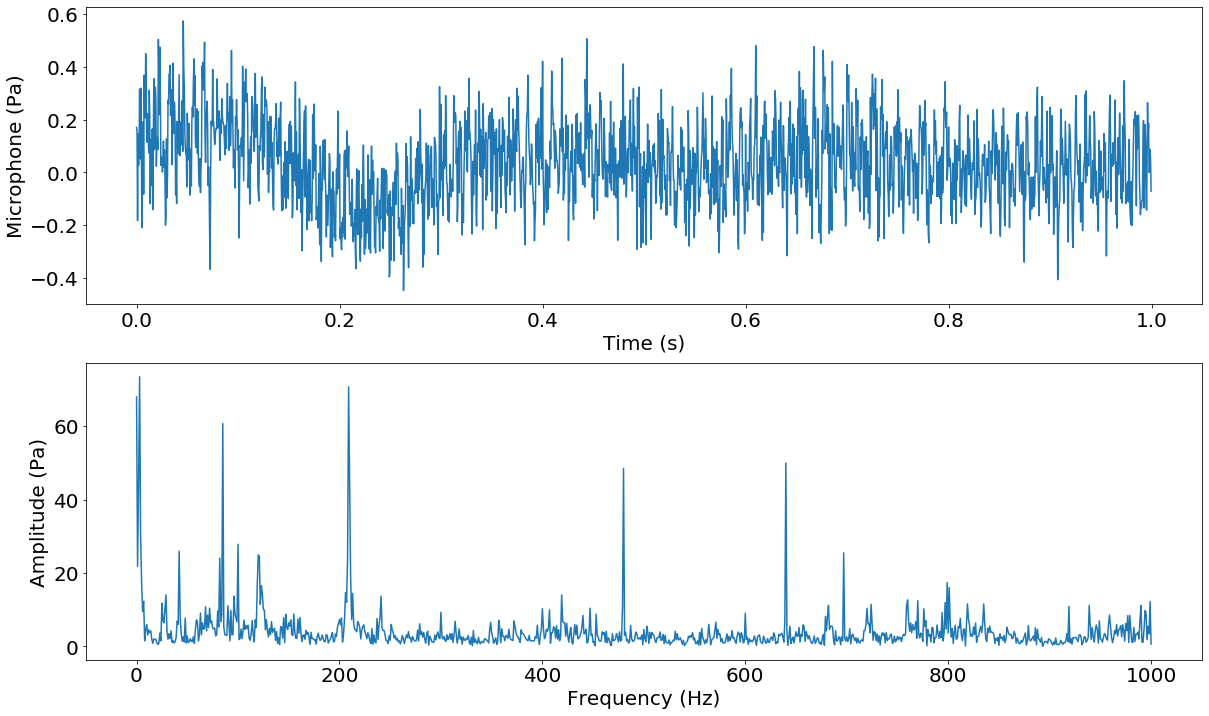

In [6]:
mpl.rcParams['figure.figsize'] = (20,10)
mpl.rc('font', **font)

plt.figure(figsize=(20,12))

plt.subplot(211)
plt.plot(x.values, df, label="Real values")
plt.ylabel("Microphone (Pa)")
plt.xlabel("Time (s)")

plt.subplot(212)
plt.plot(freq,np.abs(amp))
plt.xlabel("Frequency (Hz)")  
plt.ylabel("Amplitude (Pa)")  

Because of idea to use 10% of these amplitudes for machine learning workflow, which should be enough to reconstruct the signal and make prediction, reconstruction using 10% highest amplitudes will be shown here.

Amplitudes are sorted by their absolute values from highest to lowest.

In [7]:
coeffs = dict(zip(freq, amp))

# take top N % of coefficients  !!!! This can be changed !!!!
N=10

# taking top N % aplitudes and sorting them by value, t[1] means sorting by second column i.e. by values of dictionary
out = OrderedDict(sorted(coeffs.items(), key=lambda t: abs(t[1]), reverse=True)[:round((N/100.0)*len(freq))])  

sorted_amp=list(out.values())                  #transforming sorted dictionary to the list

Keeping only 10% choosen frequencies. 

In [8]:
threshold_apsolute_amplitude=abs(sorted_amp[-1])      #choosing the treeshold amplitude

for key, value in coeffs.items():
        if abs(value) <=threshold_apsolute_amplitude:
             coeffs[key]=0+0j
                
top_10=list(coeffs.values())

Another plot in frequency domain, will show which frequencies out of full spectrum are selected and why.

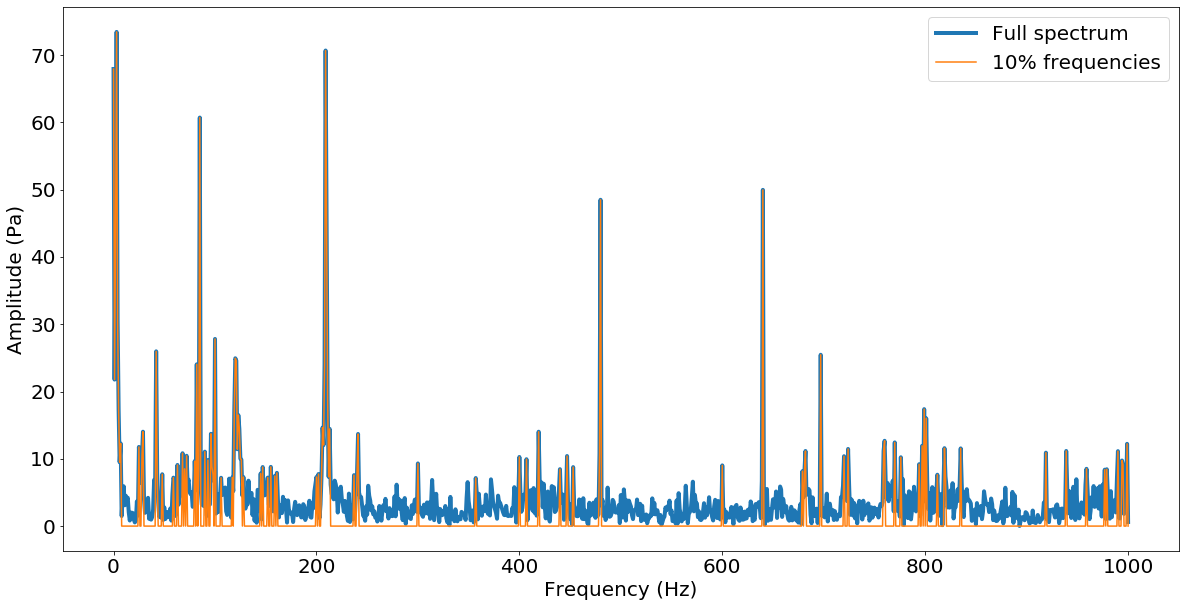

In [9]:
plt.plot(freq,np.abs(amp),zorder=1, linewidth=4,label='Full spectrum') 
plt.ylabel("Amplitude (Pa)") 

plt.plot(np.abs(top_10),zorder=2, label='10% frequencies')
plt.xlabel("Frequency (Hz)")
plt.legend()

Next plot shows sorted amplitudes, but without frequency labels.  

Text(0, 0.5, 'Amplitude (Pa)')

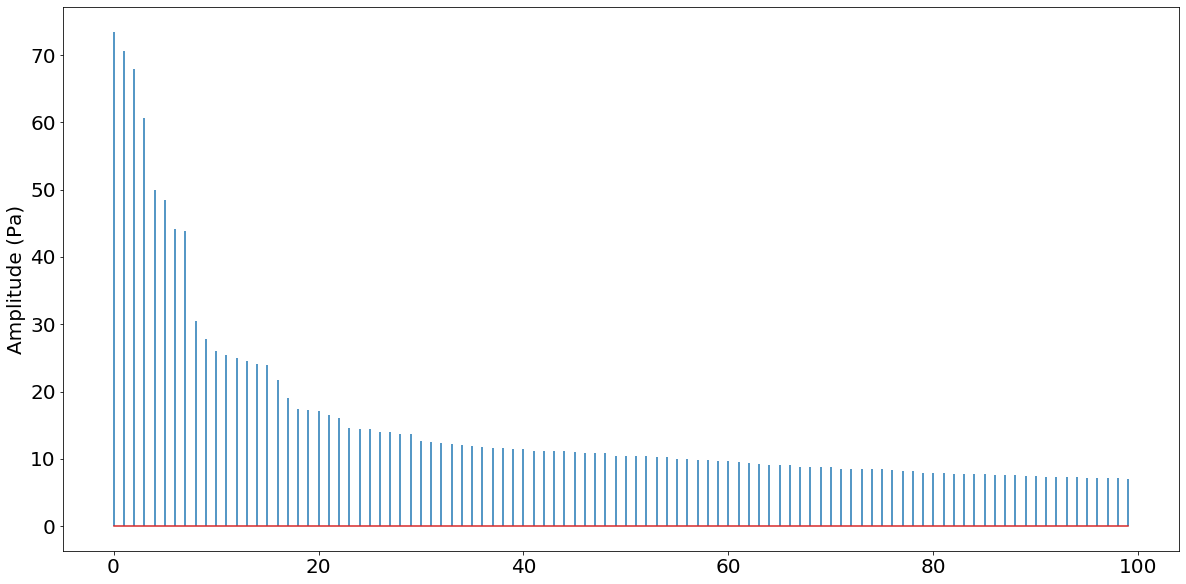

In [10]:
plt.stem(np.abs(sorted_amp), use_line_collection=True ,markerfmt=' ')
plt.ylabel("Amplitude (Pa)") 

Reconstructing using inverse fast Fourier transform will give similar sensor signal, and that is why these frequencies and amplitudes are very good features for comparing different cycles.

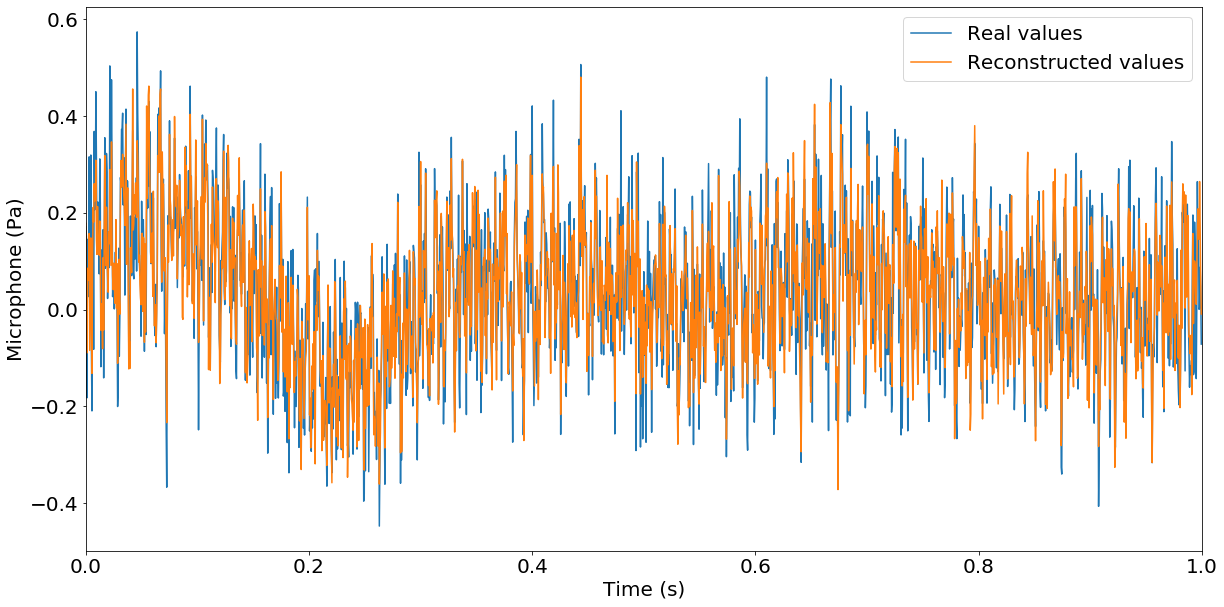

In [11]:
inverse_fft = np.fft.irfft(top_10)

plt.plot(x.values, df, label="Real values")
plt.ylabel("Microphone (Pa)")
plt.xlabel("Time (s)")
plt.plot(x.values,inverse_fft, label="Reconstructed values")
plt.xlim(0,1)
plt.legend()


This procedure can be done for every sensor and every cycle of each sensor.

### References:

[1]  PTB, ZeMA, - Deep dive into the ZeMA machine learning (ppt), January 2019

[2]  https://www.nti-audio.com/en/support/know-how/fast-fourier-transform-fft

[3]  http://www.sthda.com/english/wiki/correlation-test-between-two-variables-in-r

[4]  https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

[4]  Edouard Duchesnay, Tommy Löfstedt, - Statistics and Machine Learning in Python, March 2018


